CSCI E-82 - Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Project - Summary Notebook

### *Dominic Murphy and David Modjeska*

------

# Introduction

In [1]:
import glob
import math
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import warnings

%matplotlib inline
from IPython.display import Image, display, HTML

In [2]:
def my_display(str): 
    display(HTML(str))
    
def my_display_df(df): 
    display(HTML(df.to_html(index=False)))
    
def my_linespace():
    my_display('<p>')
    
plt.rcParams["patch.force_edgecolor"] = True   
plt.style.use('ggplot')

palette = sns.color_palette(palette = 'deep')
sns.set_palette(palette)

# Summary of results for RF, GAM, XGB, and stack models

#### Helper function to load results tables

In [3]:
def load_results_tables(file_prefix):
    summary_table = pd.DataFrame()
    filenames = glob.glob(file_prefix + '*')
    
    for filename in filenames:
        model = re.sub(file_prefix + '_(.*)_.*', '\\1', filename)
        lag = re.sub('.*_([0-9]+).csv', '\\1', filename)
        results = pd.read_csv(filename)
        results['Model'] = model
        results['Lag'] = lag
        summary_table = summary_table.append(results)
    
    return(summary_table)

#### Test RMSE for all FX rates (relative to USD)

In [4]:
rmse_summary = load_results_tables('RMSE')
rmse_summary = rmse_summary[['Lag', 'Model', 'Currency', 'Naive', 'FX Only', 'FX + Features', 'All Features']]

n_models = len(rmse_summary.Model.unique())
n_currencies = len(rmse_summary.Currency.unique())

my_linespace()
my_display_df(rmse_summary)

Lag,Model,Currency,Naive,FX Only,FX + Features,All Features
7,Stack,AUD,0.015527,0.014512,0.009683,0.007690
7,Stack,CAD,0.012055,0.011048,0.008307,0.005559
7,Stack,EUR,0.018106,0.017085,0.010540,0.008332
7,Stack,JPY,0.000147,0.000137,0.000071,0.000071
7,Stack,CHF,0.016522,0.017865,0.009079,0.007238
7,Stack,GBP,0.022896,0.021255,0.012818,0.010078
7,GAM,AUD,0.015527,0.013734,0.012198,0.009203
7,GAM,CAD,0.012055,0.010604,0.009354,0.007205
7,GAM,EUR,0.018106,0.016804,0.015947,0.011603
7,GAM,JPY,0.000147,0.000132,0.000123,0.000102


#### Test/naive RMSE for all FX rates (relative to USD)

In [5]:
rmse_summary_2 = load_results_tables('Test_Naive')
rmse_summary_2 = rmse_summary_2[['Lag', 'Model', 'Currency', 'FX Only', 'FX + Features', 
                                 'All Features']]

my_linespace()
my_display_df(rmse_summary_2)

Lag,Model,Currency,FX Only,FX + Features,All Features
7,XGB,AUD,0.890,0.717,0.647
7,XGB,CAD,0.883,0.781,0.655
7,XGB,EUR,0.914,0.782,0.675
7,XGB,JPY,0.890,0.743,0.684
7,XGB,CHF,1.045,0.828,0.615
7,XGB,GBP,0.880,0.730,0.629
7,LSTM,AUD,2.563,3.301,3.339
7,LSTM,CAD,1.744,1.602,3.197
7,LSTM,EUR,1.558,2.618,2.508
7,LSTM,JPY,1.885,3.009,4.163


### Visualize test/naive RMSE

In [6]:
def vis_test_naive(by_col_name, features_name, color_index = 0, ax = None):
    agg_data = rmse_summary_2.groupby(by_col_name)[features_name].agg(np.mean).reset_index()
    agg_data = agg_data.sort_values(by = features_name, ascending = False).reset_index()
    
    sns.barplot(x = by_col_name, y = features_name,
                data = agg_data, color = palette[color_index], ax = ax)
    
    ax.set_xlabel(by_col_name)
    ax.set_ylabel('Test/Naive RMSE')
    ax.set_title(features_name)

    # from https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 0.02,
                '{:1.2f}'.format(agg_data[features_name][i]),
                ha = "center", color = '0.2') 

    return(ax)

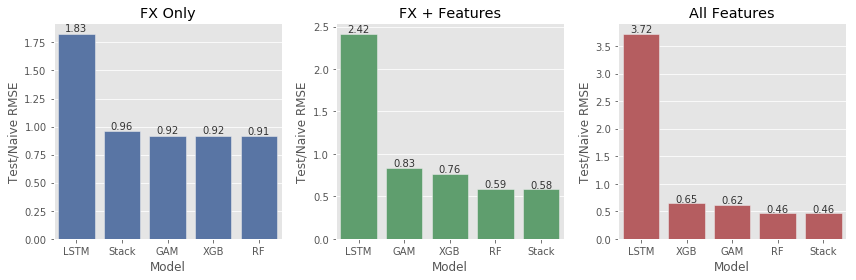

In [7]:
my_linespace()
my_display("<h4>Test/naive RMSE by model</h4>")
fix, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

ax = vis_test_naive('Model', 'FX Only', 0, axes[0])
ax = vis_test_naive('Model', 'FX + Features', 1, axes[1])
ax = vis_test_naive('Model', 'All Features', 2, axes[2])

plt.tight_layout()
plt.show()

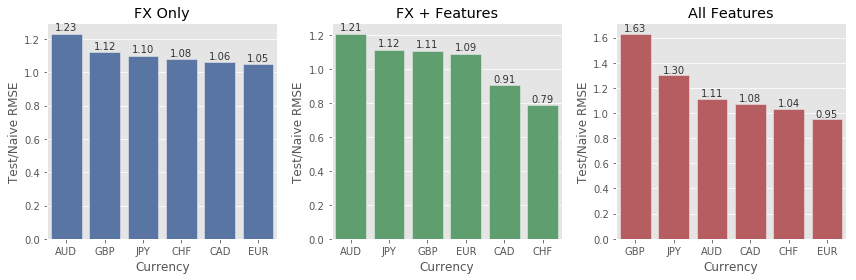

In [8]:
my_linespace()
my_display("<h4>Test/naive RMSE by currency</h4>")
fix, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

ax = vis_test_naive('Currency', 'FX Only', 0, axes[0])
ax = vis_test_naive('Currency', 'FX + Features', 1, axes[1])
ax = vis_test_naive('Currency', 'All Features', 2, axes[2])

plt.tight_layout()
plt.show()

In [9]:
def vis_model_currency(data, by_col_name, series_col_name, features_name, ax = None):
    ax.axhline(y = 1.0, color = '0.6', linestyle = '--', label = 'Naive')

    by_items = data[by_col_name].unique()
    n_by_items = len(by_items)
    
    series_items = data[series_col_name].unique()
    n_series_items = len(series_items)
    
    for i in range(n_by_items):
        this_by_item = by_items[i]
        series_data = data[data[by_col_name] == this_by_item][features_name]
        ax.plot(range(n_series_items), series_data, label = this_by_item, 
                color = palette[i])

    ax.set_xticks(range(n_series_items))
    ax.set_xticklabels(series_items)

    ax.set_xlabel(series_col_name)
    ax.set_ylabel('Test/naive RMSE')
    ax.set_title(features_name)

    ax.legend(loc = 'best')

    return(ax)

In [10]:
rmse_summary_3 = rmse_summary_2[rmse_summary_2.Model != 'LSTM']

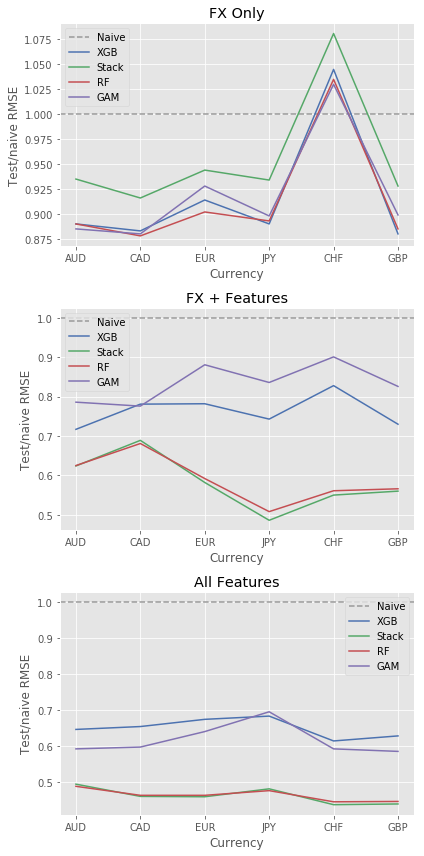

In [11]:
my_linespace()
my_display("<h4>Test/naive RMSE by currency and model</h4>")
fix, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (6, 12))

ax = vis_model_currency(rmse_summary_3, 'Model', 'Currency', 'FX Only', axes[0])
ax = vis_model_currency(rmse_summary_3, 'Model', 'Currency', 'FX + Features', axes[1])
ax = vis_model_currency(rmse_summary_3, 'Model', 'Currency', 'All Features', axes[2])

plt.tight_layout()
plt.show()

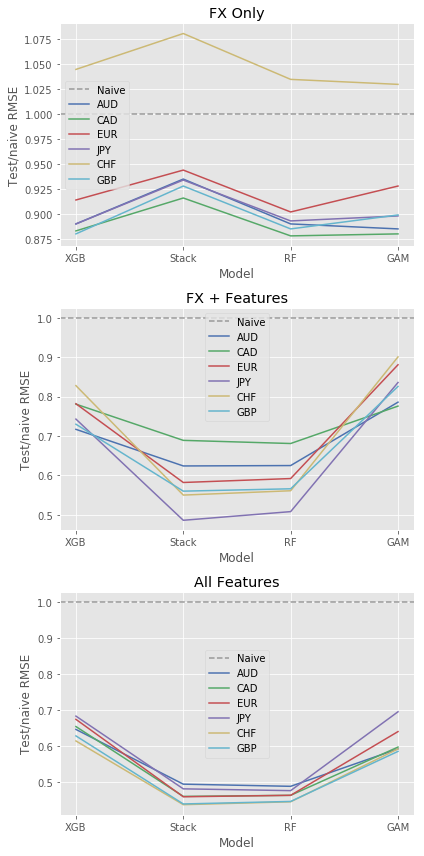

In [12]:
my_linespace()
my_display("<h4>Test/naive RMSE by model and currency</h4>")
fix, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (6, 12))

ax = vis_model_currency(rmse_summary_3, 'Currency', 'Model', 'FX Only', axes[0])
ax = vis_model_currency(rmse_summary_3, 'Currency', 'Model', 'FX + Features', axes[1])
ax = vis_model_currency(rmse_summary_3, 'Currency', 'Model', 'All Features', axes[2])

plt.tight_layout()
plt.show()